In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats

from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec

In [2]:
df_iron = pd.read_csv('../Dissertation_projects/Data/IRON/Iron.csv', sep=',', index_col=0)

#make all the spots labeled NA a nan value
df_iron = df_iron.replace('NA', np.nan)
df_iron = df_iron.replace('NA ', np.nan)

#make all BDL a 0 
df_iron.loc[df_iron['FeT_uM'] == 'BLD', 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] == 'BLD', 'Fe2_uM'] = 0

# convert columns to numeric data type
df_iron['FeT_uM'] = pd.to_numeric(df_iron['FeT_uM'], errors='coerce')
df_iron['Fe2_uM'] = pd.to_numeric(df_iron['Fe2_uM'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].where(pd.notna(df_iron['FeT_uM']), other=np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].where(pd.notna(df_iron['Fe2_uM']), other=np.nan)

#make all negative a 0 
df_iron.loc[df_iron['FeT_uM'] < 0, 'FeT_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] < 0, 'Fe2_uM'] = 0

#calculate Fe +3 
df_iron['Fe3_uM'] = df_iron['FeT_uM'] - df_iron['Fe2_uM']
df_iron.loc[df_iron['Fe3_uM'] < 0, 'Fe3_uM'] = 0
df_iron.loc[df_iron['Fe2_uM'] > df_iron['FeT_uM'], 'Fe3_uM'] = 0
df_iron['Fe3_uM'] = pd.to_numeric(df_iron['Fe3_uM'], errors='coerce')
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].where(pd.notna(df_iron['Fe3_uM']), other=np.nan)

#time feild 
df_iron['Fe2_Time'] = pd.to_numeric(df_iron['Fe2_Time'], errors='coerce')
df_iron['Fe2_Time'] = df_iron['Fe2_Time'].where(pd.notna(df_iron['Fe2_Time']), other=np.nan)

#time feild 
df_iron['FeT_Time'] = pd.to_numeric(df_iron['FeT_Time'], errors='coerce')
df_iron['FeT_Time'] = df_iron['FeT_Time'].where(pd.notna(df_iron['FeT_Time']), other=np.nan)

# convert columns to numeric data type
df_iron['FeT_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')
df_iron['Fe2_Depth'] = pd.to_numeric(df_iron['Fe2_Depth'], errors='coerce')

df_iron['FeT_uM'] = df_iron['FeT_uM'].replace(0, np.nan)
df_iron['Fe2_uM'] = df_iron['Fe2_uM'].replace(0, np.nan)
df_iron['Fe3_uM'] = df_iron['Fe3_uM'].replace(0, np.nan)

df_iron['code'] = df_iron['Location'] + '_' + df_iron['Campaign']

In [3]:
df_doc = pd.read_csv('../Dissertation_projects/Data/TOC/TOC_GOM.csv', sep=',', index_col=0)

#make all BDL a 0 
df_doc.loc[df_doc['NPOC_uM'] == 'BLD', 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] == 'BLD', 'TN_uM'] = 0

df_doc.loc[df_doc['NPOC_uM'] < 0, 'NPOC_uM'] = 0
df_doc.loc[df_doc['TN_uM'] < 0, 'TN_uM'] = 0

#fix date time 
df_doc['date_time'] = pd.to_datetime(df_doc['Date'])
df_doc['Date'] = df_doc['date_time'].dt.date

df_doc['NPOC_uM'] = pd.to_numeric(df_doc['NPOC_uM'], errors='coerce')
df_doc['NPOC_uM'] = df_doc['NPOC_uM'].where(pd.notna(df_doc['NPOC_uM']), other=np.nan)

df_doc['TN_uM'] = pd.to_numeric(df_doc['TN_uM'], errors='coerce')
df_doc['TN_uM'] = df_doc['TN_uM'].where(pd.notna(df_doc['TN_uM']), other=np.nan)

df_doc['Time'] = pd.to_numeric(df_doc['Time'], errors='coerce')
df_doc['Time'] = df_doc['Time'].where(pd.notna(df_doc['Time']), other=np.nan)

df_doc['NPOC_uM'] = df_doc['NPOC_uM'].replace(0, np.nan)
df_doc['TN_uM'] = df_doc['TN_uM'].replace(0, np.nan)

df_doc['code'] = df_doc['Location'] + '_' + df_doc['Campaign']

In [4]:
df_meta = pd.read_csv('../Dissertation_projects/Data/meta_data.csv', sep=',', index_col=0)

#fix date time 
df_meta['date_time'] = pd.to_datetime(df_meta['Date'])
df_meta['Date'] = df_meta['date_time'].dt.date

df_meta['code'] = df_meta['Station'] + '_' + df_meta['Trip']

In [5]:
df_c = pd.read_csv('../Dissertation_projects/Data/CDOM/Outputs.csv', sep=',', index_col=0)

df_c['Sample_idx'] = df_c.index.astype(object)
df_meta['Sample_idx'] = df_meta.index.astype(object)

df_c.index = df_c['file_id']

df_cdom = df_c.merge(df_meta, on="Sample_idx", how="left")

df_cdom.index = df_cdom['Sample_idx']
df_cdom['Sample'] = df_cdom.index
df_cdom.index = df_cdom['Sample']
df_cdom = df_cdom.drop('Sample_idx', axis = 1)
df_meta = df_meta.drop('Sample_idx', axis = 1)

In [6]:
df_por = pd.read_csv('../Dissertation_projects/Data/Porosity/Porosity.csv', sep=',', index_col = 0)

df_por['code'] = df_por['Stn'] + '_' + df_por['camp']

In [7]:
df_hights = pd.read_csv('../Dissertation_projects/Data/Hights.csv', sep=',')

df_hights['code'] = df_hights['Stn'] + '_' + df_hights['Camp']
#df_hights.drop("Stn", axis=1, inplace=True)
#df_hights.drop("Camp", axis=1, inplace=True)
df_hights.index = df_hights['code']
df_hights.drop("code", axis=1, inplace=True)

In [8]:
df_spectra_bc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_BC.csv',sep=',', index_col=0)
df_spectra_pw = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
df_spectra_wc = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_WC.csv',sep=',', index_col=0)
df_spectra_rz = pd.read_csv('../Dissertation_projects/Data/CDOM/sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

df_spectra_bc.columns = ['a' + col for col in df_spectra_bc.columns]
df_spectra_pw.columns = ['a' + col for col in df_spectra_pw.columns]
df_spectra_wc.columns = ['a' + col for col in df_spectra_wc.columns]
df_spectra_rz.columns = ['a' + col for col in df_spectra_rz.columns]

In [9]:
#get BC data sets 
df_cdom_bc = df_cdom[df_cdom['Type'] == 'LANDSYR']
df_iron_bc = df_iron[df_iron['Type'] == 'BC']
df_doc_bc = df_doc[df_doc['Type'] == 'BC']

#get PW data sets 
df_cdom_pw = df_cdom[df_cdom['Type'] == 'PW']
df_iron_pw = df_iron[df_iron['Type'] == 'PW']
df_doc_pw = df_doc[df_doc['Type'] == 'PW']

#get WC data sets 
df_cdom_wc = df_cdom[df_cdom['Type'] == 'NISK']
df_iron_wc = df_iron[df_iron['Type'] == 'WC']
df_doc_wc = df_doc[df_doc['Type'] == 'WC']

#get RHZ data 
df_cdom_rz = df_cdom[df_cdom['Type'] == 'RHZ']
df_iron_rz = df_iron[df_iron['Type'].isin(['RZ', 'GBRZ'])]
df_doc_rz = df_doc[df_doc['Type'] == 'RZ']

In [10]:
#Put all the BC data together 
#remove repeat rows 
df_cdom_bc_cl = df_cdom_bc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_bc_cl = df_iron_bc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_bc_cl = df_doc_bc.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_bc_cl.index = df_cdom_bc_cl.index.astype(str)
df_iron_bc_cl.index = df_iron_bc_cl.index.astype(str)
df_doc_bc_cl.index = df_doc_bc_cl.index.astype(str)
df_spectra_bc.index = df_spectra_bc.index.astype(str)


#combind DOC and CDOM data 
df_bc = df_spectra_bc.join(df_doc_bc_cl)
df_bc = df_bc.join(df_cdom_bc_cl)

#match up the inxdes for the merge 
df_iron_bc_cl['sample_index'] = df_iron_bc_cl.index.astype(str)
df_bc.index = df_bc.index.astype(str)

#combind the iron data 
df_bc = df_bc.join(df_iron_bc_cl)
df_meta.index = df_meta.index.astype(str)

df_bc = df_meta.merge(df_bc, left_index=True, right_index=True)

#################################################

#Put all the PW data together 
#remove repeat rows 
df_cdom_pw_cl = df_cdom_pw.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_pw_cl = df_iron_pw.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_pw_cl = df_doc_pw.drop(['Treatment','Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_pw_cl.index = df_cdom_pw_cl.index.astype(str)
df_iron_pw_cl.index = df_iron_pw_cl.index.astype(str)
df_doc_pw_cl.index = df_doc_pw_cl.index.astype(str)
df_spectra_pw.index = df_spectra_pw.index.astype(str)


#combind DOC and CDOM data 
df_pw = df_spectra_pw.join(df_doc_pw_cl)
df_pw = df_pw.join(df_cdom_pw_cl)

#match up the inxdes for the merge 
df_iron_pw_cl['sample_index'] = df_iron_pw_cl.index.astype(str)
df_pw.index = df_pw.index.astype(str)

#combind the iron data 
df_pw = df_pw.join(df_iron_pw_cl)

df_pw = df_meta.merge(df_pw, left_index=True, right_index=True)

###############################################

#Put all the WC data together 
#remove repeat rows 
df_cdom_wc_cl = df_cdom_wc.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_wc_cl = df_iron_wc.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_wc_cl = df_doc_wc.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_wc_cl.index = df_cdom_wc_cl.index.astype(str)
df_iron_wc_cl.index = df_iron_wc_cl.index.astype(str)
df_doc_wc_cl.index = df_doc_wc_cl.index.astype(str)
df_spectra_wc.index = df_spectra_wc.index.astype(str)

#combind DOC and CDOM data 
df_wc = df_spectra_wc.join(df_doc_wc_cl)
df_wc = df_wc.join(df_cdom_wc_cl)

#match up the inxdes for the merge 
df_iron_wc_cl['sample_index'] = df_iron_wc_cl.index.astype(str)
df_wc.index = df_wc.index.astype(str)

#combind the iron data 
df_wc = df_wc.join(df_iron_wc_cl)

df_wc = df_meta.merge(df_wc, left_index=True, right_index=True)

##################################################

#Put all the RZ data together 
#remove repeat rows 
df_cdom_rz_cl = df_cdom_rz.drop(['Date', 'Type', 'Notes', 'date_time', 'code', 'Trip', 'Salinity',
                                 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
                                 'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
                                 'BC_Chamber_vol_(L)', 'Waveguide_used', 'Flagged', 'file_id'], axis=1)
df_iron_rz_cl = df_iron_rz.drop(['Treatment', 'Campaign', 'Location', 'Type', 'code'], axis=1)
df_doc_rz_cl = df_doc_rz.drop(['Treatment', 'Campaign', 'Location','Date', 'Type','Depth', 'Notes', 
                               'Time','code','date_time'], axis=1)

df_cdom_rz_cl.index = df_cdom_rz_cl.index.astype(str)
df_iron_rz_cl.index = df_iron_rz_cl.index.astype(str)
df_doc_rz_cl.index = df_doc_rz_cl.index.astype(str)
df_spectra_rz.index = df_spectra_rz.index.astype(str)

#combind DOC and CDOM data 
df_rz = df_spectra_rz.join(df_doc_rz_cl)
df_rz = df_rz.join(df_cdom_rz_cl)

#match up the inxdes for the merge 
df_iron_rz_cl['sample_index'] = df_iron_rz_cl.index.astype(str)
df_rz.index = df_rz.index.astype(str)

#combind the iron data 
df_rz = df_rz.join(df_iron_rz_cl)

#add the meta data 
df_rz = df_meta.merge(df_rz, left_index=True, right_index=True)

In [11]:
#litte clean ups with outliters 
df_pw.loc[df_pw['NPOC_uM'] > 4000, 'NPOC_uM'] = np.nan

df_bc.loc[df_bc['FeT_uM'] > 1, 'FeT_uM'] = np.nan
df_bc.loc[df_bc['Fe3_uM'] > 1, 'Fe3_uM'] = np.nan
df_bc.loc[df_bc['FeT_uM'] == 0, 'FeT_uM'] = np.nan
df_bc.loc[df_bc['Fe3_uM'] == 0, 'Fe3_uM'] = np.nan
df_bc.loc[df_bc['Fe2_uM'] == 0, 'Fe2_uM'] = np.nan

df_bc.loc[df_bc['a350'] > 2, 'a350'] = np.nan
df_bc.loc[df_bc['a412'] > 1.5, 'a412'] = np.nan
df_bc.loc[df_bc['NPOC_uM'] < .000005, 'NPOC_uM'] = np.nan
df_bc.loc[df_bc['TN_uM'] < .000005, 'TN_uM'] = np.nan

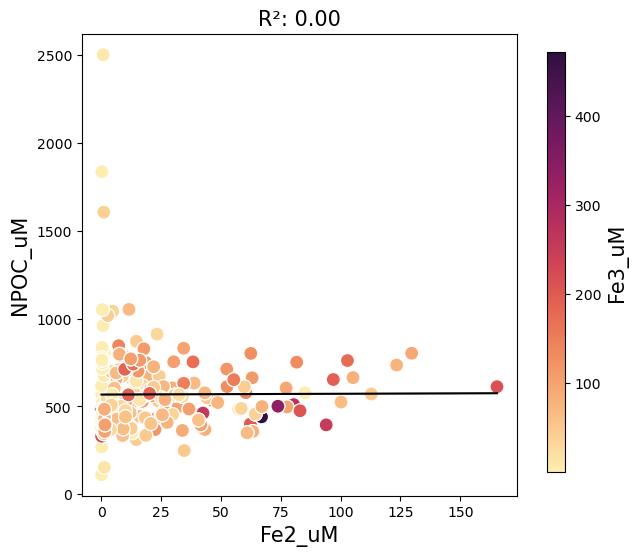

In [12]:
def xyplotcolor(df_choice):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df_choice.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = df_choice[z_var].min()
    vmax = df_choice[z_var].max()

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.show()
    
    
x_var = 'Fe2_uM'
y_var = 'NPOC_uM'

x_var_lab = 'Fe2_uM'
y_var_lab = 'NPOC_uM'

z_var = 'Fe3_uM'
z_var_lab = 'Fe3_uM'
z_var_color = cmo.matter

titel = ""

df_pw['Sample_depth'] = pd.to_numeric(df_pw['Sample_depth'], errors='coerce')
#df_choice = df_pw[df_pw['Sample_depth'] >= 0]
#df_choice = df_choice[df_choice['Sample_depth'] <= 5]

xyplotcolor(df_choice)

In [13]:
df_choice.columns

Index(['Date', 'Trip', 'Station', 'Lat', 'Lon', 'Water_depth', 'Sample_depth',
       'Sample_depth_units', 'Wavguide_Path_lengths', 'BC_time',
       ...
       'FeT_Depth', 'FeT_Time', 'Fe2_Date', 'Fe2_uM', 'Fe2_mgL', 'Fe2_Notes',
       'Fe2_Depth', 'Fe2_Time', 'Fe3_uM', 'sample_index'],
      dtype='object', length=572)

In [35]:
df_choice['code'] = df_choice['Station'] + '_' + df_choice['Trip']

df_choice['NPOC_mean'] = df_choice.groupby('code')['NPOC_uM'].transform('mean')
df_choice['NPOC_norm'] = df_choice['NPOC_uM'] - df_choice['NPOC_mean'] 

df_choice['Fe2_mean'] = df_choice.groupby('code')['Fe2_uM'].transform('mean')
df_choice['Fe2_norm'] = df_choice['Fe2_uM'] - df_choice['Fe2_mean'] 

df_choice['Fe2_mean'].min()

0.07628571428571428

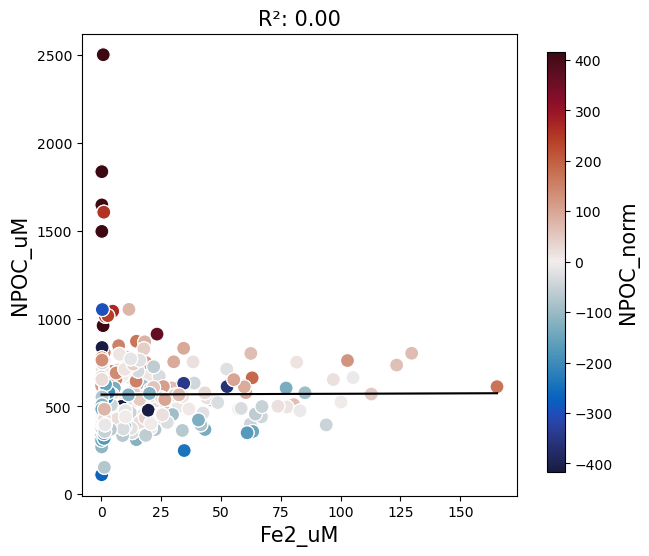

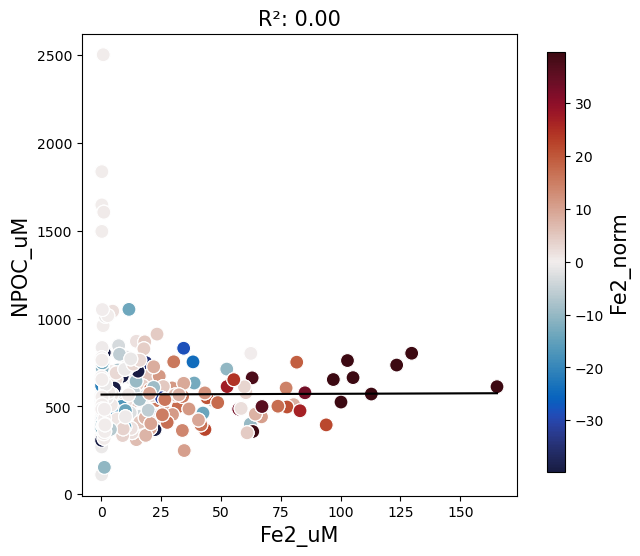

In [37]:

def xyplotcolor_dev(df_choice):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    model = LinearRegression()
    sub = df_choice.dropna(subset=[x_var, y_var])
    data = sub[[x_var, y_var, z_var]]
    colors = data[z_var].astype(float)

    vmin = df_choice[z_var].std()*-2
    vmax = df_choice[z_var].std()*2

    X = data[[x_var]]
    y = data[y_var]
    model.fit(X, y)
    score = model.score(X, y)

    sns.scatterplot(x=x_var, y=y_var, c=colors, cmap=z_var_color, s=100, data=data, ax=axes, legend=False , vmin=vmin, vmax=vmax)
    sns.lineplot(x=X[x_var], y=model.predict(X), ax=axes, color='black')

    axes.set_xlabel(x_var.replace(x_var, x_var_lab), size=15)
    axes.set_ylabel(y_var.replace(y_var, y_var_lab), size=15)

    axes.set_title(titel + f'R\u00B2: {score:.2f}', size = 15)

    # Add a color bar for the depth on the right side of the figure
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=z_var_color, norm=plt.Normalize(vmin=vmin, vmax=vmax)), cax=cbar_ax)
    cbar.ax.set_ylabel(z_var_lab, size=15)

    # Show the plot
    plt.show()

x_var = 'Fe2_uM'
y_var = 'NPOC_uM'

x_var_lab = 'Fe2_uM'
y_var_lab = 'NPOC_uM'

z_var = 'NPOC_norm'
z_var_lab = 'NPOC_norm'
z_var_color = cmo.balance

titel = ""

xyplotcolor_dev(df_choice)


x_var = 'Fe2_uM'
y_var = 'NPOC_uM'

x_var_lab = 'Fe2_uM'
y_var_lab = 'NPOC_uM'

z_var = 'Fe2_norm'
z_var_lab = 'Fe2_norm'
z_var_color = cmo.balance

titel = ""

xyplotcolor_dev(df_choice)

In [38]:
high_fe2 = df_choice[df_choice['Fe2_norm'] >= 0]
low_fe2 = df_choice[df_choice['Fe2_norm'] <= 0]



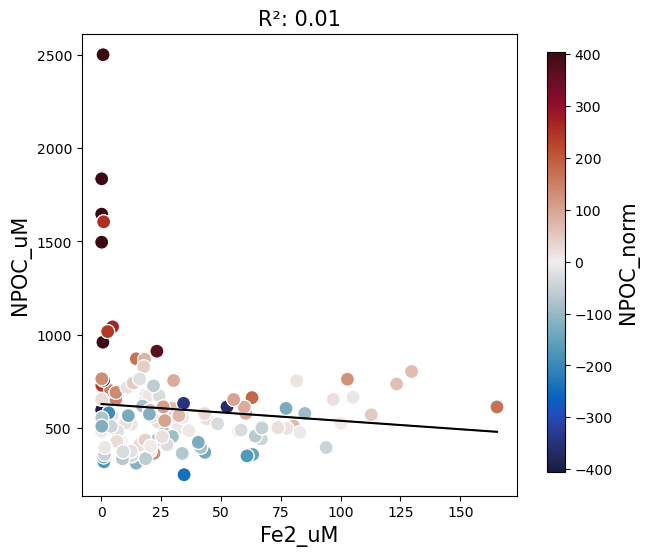

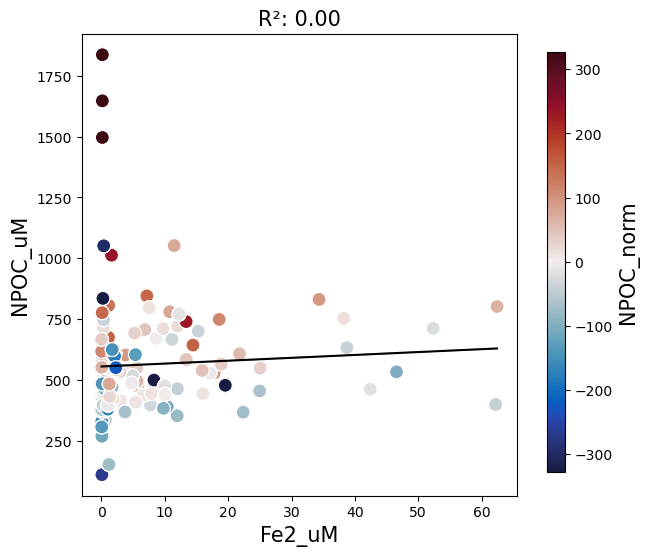

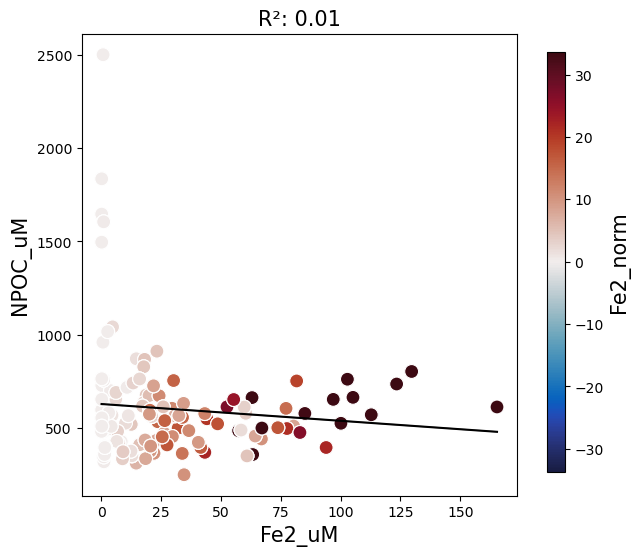

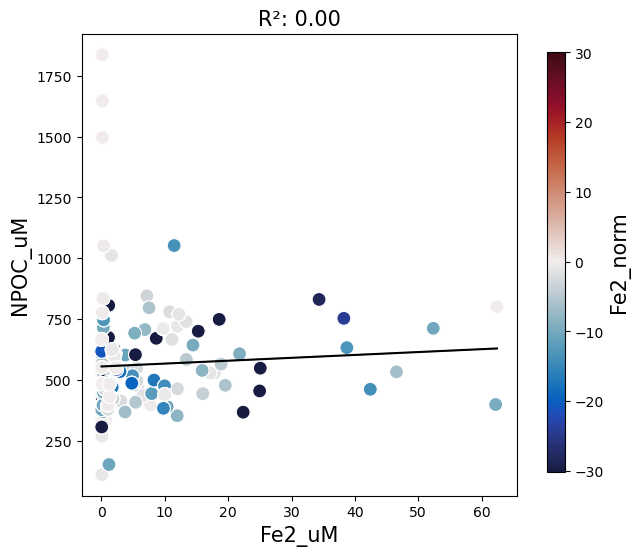

In [41]:
x_var = 'Fe2_uM'
y_var = 'NPOC_uM'

x_var_lab = 'Fe2_uM'
y_var_lab = 'NPOC_uM'

z_var = 'NPOC_norm'
z_var_lab = 'NPOC_norm'
z_var_color = cmo.balance

titel = ""


xyplotcolor_dev(high_fe2)
xyplotcolor_dev(low_fe2)


x_var = 'Fe2_uM'
y_var = 'NPOC_uM'

x_var_lab = 'Fe2_uM'
y_var_lab = 'NPOC_uM'

z_var = 'Fe2_norm'
z_var_lab = 'Fe2_norm'
z_var_color = cmo.balance

titel = ""


xyplotcolor_dev(high_fe2)
xyplotcolor_dev(low_fe2)

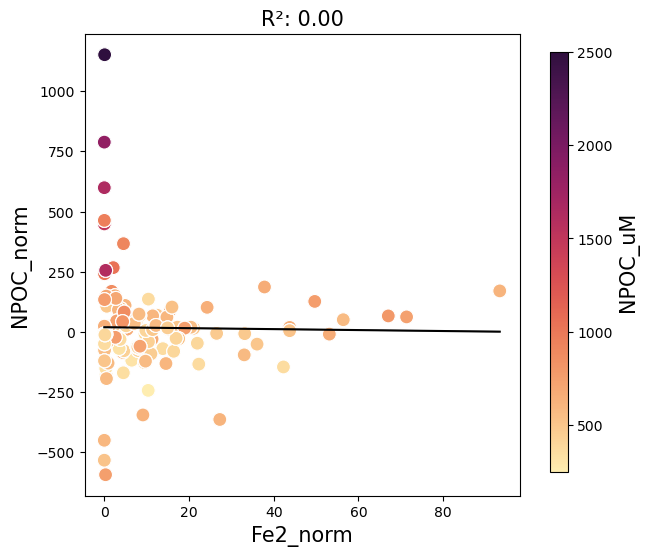

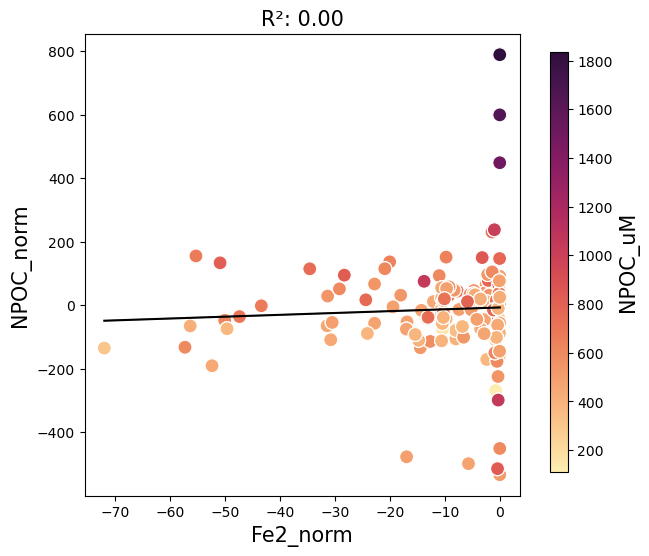

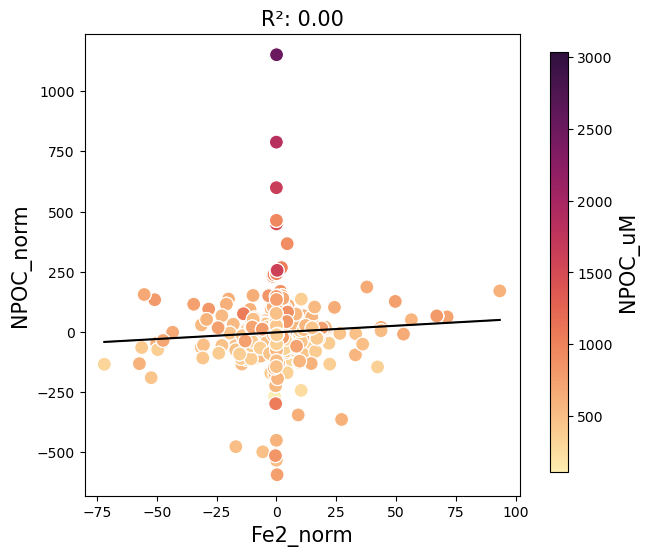

In [42]:
x_var = 'Fe2_norm'
y_var = 'NPOC_norm'

x_var_lab = 'Fe2_norm'
y_var_lab = 'NPOC_norm'

z_var = 'NPOC_uM'
z_var_lab = 'NPOC_uM'
z_var_color = cmo.matter

titel = ""


xyplotcolor(high_fe2)
xyplotcolor(low_fe2)
xyplotcolor(df_choice)